In [1]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# # model parameters
# import json
# with open('/mnt/inca/soc_eu_model/data/006_params_annual.json', 'r') as file:
#     params = json.load(file)
    
# covariates, best feature set
with open('/mnt/inca/soc_eu_model/data/004.1_selected.covar_all.rank.freq.txt', 'r') as file:
    lines = file.readlines()
covs = [line.strip() for line in lines]

# training data
df = pd.read_csv('/mnt/inca/soc_eu_model/data/002_covar_overlayed.csv',low_memory=False)
def clean_prop(df, prop, limit):
    print(f'\033[1mCleaning {prop}\033[0m')
    tot = len(df)
    print(f'originally with {tot} rows')
    # Clean NaN
    num = df[prop].isna().sum()
    ccol = df.loc[df[prop].isna()]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with NaN, from {ccol}')
    df = df.dropna(subset=[prop])
    
    # check if there are string values that cannot be converted to numerical values,
    # usually it's <LOD (limit of detection), such as '<6', '<LOD', etc
#     df.loc[:,prop] = pd.to_numeric(df.loc[:,prop], errors='coerce')
    df[prop] = pd.to_numeric(df[prop], errors='coerce')
    num = df[prop].isna().sum()
    ccol = df.loc[df[prop].isna()]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with invalid strings, from {ccol}')
    df = df.dropna(subset=[prop])
    
    # Check for values below 0, which are invalid for all properties
    num = len(df.loc[df[prop] < 0])
    ccol = df.loc[df[prop] < 0]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with {prop} < 0, from {ccol}')
    df = df[df[prop] >= 0]
    
    # check for values higher than plausible limit
    if limit:
        num = len(df.loc[df[prop]>limit])
        ccol = df.loc[df[prop]>limit]['ref'].unique()
        print(f'{num} ({num/tot*100:.2f}%) rows with {prop} > limit values, from {ccol}')
        df = df[df[prop] < limit]
    
    print(f'{len(df)} valid data records left')
    return df

tgt = 'oc'
dff = clean_prop(df,tgt,1000)
print()
dff = dff.dropna(subset=covs, how='any')

dff['log1p_oc'] = np.log1p(dff['oc'])
tgt = 'log1p_oc'

print(f'{len(dff)} valid data records left after cleaning covariates')
dff.reset_index(drop=True, inplace=True)

Cleaning oc
originally with 177792 rows
18009 (10.13%) rows with NaN, from ['portugal.infosolo' 'swiss.nabo' 'foregs' 'nl.bis' 'estonia.kese' 'ukceh'
 'SoDaH' 'gemas' 'croatia.multione' 'netherland.BHR-P' 'Castilla.y.Leon'
 'geocradle' 'MarSOC' 'basque' 'LUCAS']
266 (0.15%) rows with invalid strings, from ['LUCAS']
1405 (0.79%) rows with oc < 0, from ['nl.bis' 'Czech' 'LUCAS' 'Wales.GMEP']
25 (0.01%) rows with oc > limit values, from ['estonia.kese']
158087 valid data records left

152550 valid data records left after cleaning covariates


### Quantil RF training

In [ ]:
param_grid = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [10, 20, 30],
    'max_features': [0.3, 0.5, 0.7, 'log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [9]:
from quantile_forest import RandomForestQuantileRegressor
from sklearn.model_selection import train_test_split
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint

train_set, test_set = train_test_split(dff, test_size=0.4, random_state=42)

ttprint('start fitting model')
qrf = RandomForestQuantileRegressor(**params, random_state=0, n_jobs=80)
qrf.fit(train_set[covs], train_set[tgt])
ttprint('end fitting model')

import numpy as np
# Calculate the lower and upper quantile values on the test data.
y_pred_interval = qrf.predict(test_set[covs], quantiles=[0.05,0.95])
y_pred_low = y_pred_interval[:, 0]
y_pred_upp = y_pred_interval[:, 1]
y_pis = np.stack([y_pred_low, y_pred_upp], axis=1)

# Calculate the point predictions on the test data.
y_pred = qrf.predict(test_set[covs], quantiles="mean", aggregate_leaves_first=False)

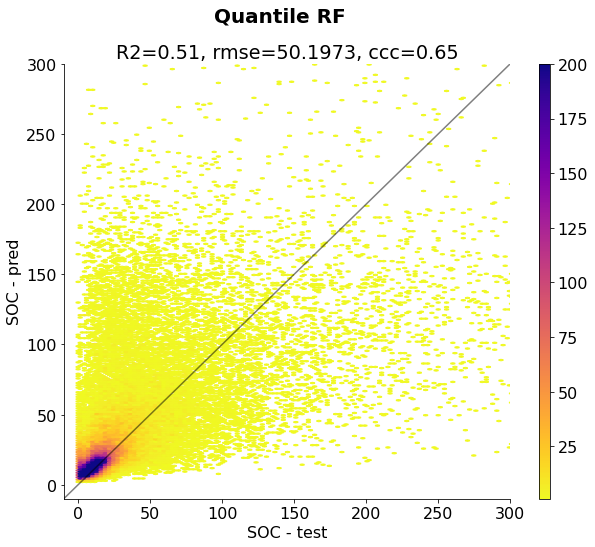

In [30]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

def calc_ccc(y_true, y_pred):
    pearson_corr = pearsonr(y_true, y_pred)[0]
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    ccc = (2 * pearson_corr * np.sqrt(var_true) * np.sqrt(var_pred)) / (var_true + var_pred + (mean_true - mean_pred)**2)
    return ccc
    
def accuracy_plot(y_test, y_pred, title_text):

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ccc = calc_ccc(y_test, y_pred)

    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize = (8,8))
    fig.suptitle(title_text, fontsize=20, fontweight='bold')
    plt.title(f'R2={r2:.2f}, rmse={rmse:.4f}, ccc={ccc:.2f}')
    plt.hexbin(y_test, y_pred, gridsize=(300, 300) , cmap = 'plasma_r', mincnt=1, vmax = 200)#, xscale =25, yscale = 25)
    
    plt.xlabel('SOC - test'), plt.ylabel('SOC - pred')

    # square plot
    ax = plt.gca()
    ax.set_aspect('auto', adjustable='box')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #diagonal 
    ax.plot([-10, 300], [-10, 300], "-k", alpha = .5)
    ax.set_xlim(-10,300)
    ax.set_ylim(-10,300)
    
    # Create new axes according to image position
    cax = fig.add_axes([ax.get_position().x1+0.05,
                        ax.get_position().y0,
                        0.02,
                        ax.get_position().height])

    # Plot vertical colorbar
    cb = plt.colorbar(cax=cax)
    #cb.outline.set_visible(False)
    #cb.set_ticks([1,100,200,300])

    plt.show()
    
accuracy_plot(test_set[tgt], y_pred, title_text='Quantile RF')

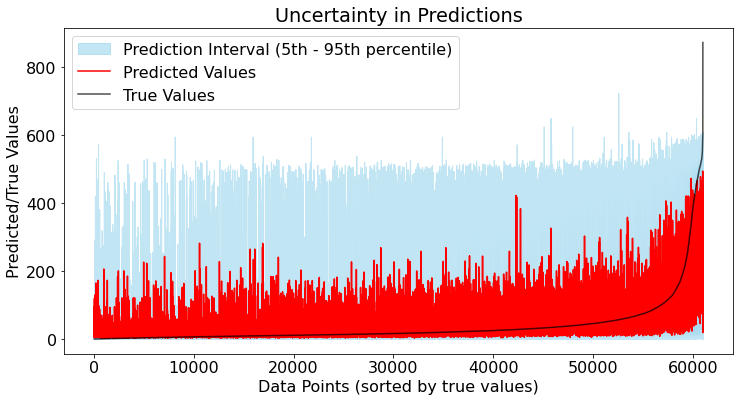

In [35]:
import matplotlib.pyplot as plt
import numpy as np

